In [38]:
import pandas as pd
import os
from project.dataset import Dataset, VALDODataset
from project.preprocessing import z_score_normalization, min_max_normalization, NiftiToTensorTransform, get_transform
# from project.preprocessing import z_score_normalization, min_max_normalization
# from project.training import split_train_val_datasets
from project.utils import collate_fn, plot_all_slices, plot_all_slices_from_array, collatev2, compute_statistics
from torch.utils.data import DataLoader
import torch
from project.model import VisionTransformer, ISAVIT
from torch.optim import Adam
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from project.model.feeder import Feeder
import seaborn as sns

In [39]:
import logging
from datetime import datetime as dtt
import os

path = 'logs'
os.makedirs(path, exist_ok=True)
dte = dtt.now().strftime('%b_%d_%Y_%H%M%S')

logger = logging.getLogger('andy')
fh = logging.FileHandler(f'logs/{dte}.log')
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s - %(message)s'
)

logger.setLevel(logging.DEBUG)
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)

logger.addHandler(fh)

dte

'Nov_06_2024_212937'

In [40]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Config for fitter

In [41]:
image_size = 300
patch_size = 50

config = {
    'model': ISAVIT(
        d_model=512,
        patch_size=patch_size,
        dim_ff=1600
    ).to(device),
    'optimizer': torch.optim.Adam,
    'device': device,
    'epochs': 50,
    'loss': nn.BCEWithLogitsLoss(),
    # 'loss': nn.MSELoss(),
    'lr': 0.00001
}

c:\Users\Lex Zedrick Lorenzo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [42]:
ds = Dataset()

data = pd.read_csv('targets.csv')
data.shape

(7986, 7)

In [43]:
data = data.query('has_microbleed_slice == 1').reset_index(drop=True)
feed_data = data[data.cohort == 1]
# data

# Feeder Dataset

In [44]:
feedset = VALDODataset(
    cases=feed_data.mri.tolist(),
    masks=feed_data.masks.tolist(),
    target=feed_data.target.tolist(),
    transform=NiftiToTensorTransform(target_shape = (300, 300), rpn_mode=True),
)

# Feeder

In [45]:
resize = get_transform(
    height=patch_size,
    width=patch_size,
    p=1.0,
    rpn_mode=False
)

In [46]:
feeder = Feeder(resize)

### `DataLoader` Generator

In [47]:
def iqr(data, col):
    q3 = data[col].quantile(0.75)
    q1 = data[col].quantile(0.25)
    iqr = q3-q1
    new = data[(data[col] < (q3 + 1.5*iqr)) & (data[col] > (q1 - 1.5*iqr))]
    return new

In [48]:
from sklearn.model_selection import train_test_split

def make_loaders(data,
                 cohort,
                 batch_size,
                 test_size=0.2,
                 random_state=12,
                 target_shape=(300, 300),
                 rpn_mode=True,
                 logger=None
                ):
    data = data[data.cohort == cohort]
    # data = iqr(data, 'max_value')
    
    s = f'Creating loaders for Cohort {cohort}\n'

    data_train, data_test = train_test_split(
        data,
        test_size=test_size,
        random_state=random_state
    )

    s += f'TRAIN & TEST: {data_train.shape, data_test.shape}\n'

    paths = data_train.mri.unique().tolist()
    s += f'Total Unique MRI Samples in data_train: {len(paths)}\n'
    
    global_min, global_max = compute_statistics(paths)
    s += f'GLOBAL MIN & MAX {global_min, global_max}\n'

    transform = NiftiToTensorTransform(
        target_shape=target_shape,
        rpn_mode=rpn_mode,
        normalization=(global_min, global_max)
    )

    train_set = VALDODataset(
        cases=data_train.mri.tolist(),
        masks=data_train.masks.tolist(),
        target=data_train.target.tolist(),
        transform=transform
    )
    val_set = VALDODataset(
        cases=data_test.mri.tolist(),
        masks=data_test.masks.tolist(),
        target=data_test.target.tolist(),
        transform=transform
    )

    train_loader = DataLoader(
        train_set,
        shuffle=True,
        batch_size=batch_size,
        collate_fn=collatev2
    )
    val_loader = DataLoader(
        val_set,
        shuffle=True,
        batch_size=batch_size,
        collate_fn=collatev2
    )

    if logger != None:
        logger.info(s)
    else:
        print(s)
    
    return train_loader, val_loader

### Fitter

In [49]:
from project import Fitter

class ViTFitter(Fitter):
    
    def fit(self, train_loader, val_loader):
        train_history = []
        val_history = []
        for epoch in range(self.epochs):
            self.log(f'EPOCH {epoch} ==============================')
            train_loss = self.train_one_epoch(train_loader)
            val_loss = self.validation(val_loader)
            train_history.append(train_loss)
            val_history.append(val_loss)
        return train_history, val_history

    def train_one_epoch(self, train_loader):
        self.model.train()
        loss_history = []
        counter = 0
        for batch in train_loader:
            Y = []
            T = []
            for slices, masks, target, case in batch:
                slices = slices.squeeze(1).float()
                masks = masks.float()

                regions = feedset.locate_case_by_mri(case)
                bbox = regions[1][target].squeeze().round().int().tolist()
                
                x = feeder(slices, bbox, 100)
                t = feeder(masks, bbox, 100)

                x = x.flatten(2).float().to(self.device)
                t = t.flatten(2).float().to(self.device)
                # self.log(f'XT SHAPES: {x.shape}, {t.shape}')
                
                y = self.model(x, target)
                Y.append(y)
                T.append(t[target])
            
            losses = self.loss(torch.stack(Y), torch.stack(T))
            self.optimizer.zero_grad()
            losses.backward()
            self.optimizer.step()
            counter += 1
            self.log(f'Batch:\t{counter}/{len(train_loader)}')
            self.log(f'Batch samples:\t{len(batch)}')
            self.log(f'Current error:\t{losses}\n')
            
            loss_history.append(losses.detach().cpu().numpy())
        
        return loss_history
    def validation(self, val_loader):
        self.model.eval()
        loss_history = []
        with torch.inference_mode():
            for batch in val_loader:
                Y = []
                T = []
                for slices, masks, target, case in batch:
                    slices = slices.squeeze(1).float()
                    masks = masks.float()
                    regions = feedset.locate_case_by_mri(case)
                    bbox = regions[1][target].squeeze().round().int().tolist()
                
                    x = feeder(slices, bbox, 100)
                    t = feeder(masks, bbox, 100)
                    x = x.flatten(2).float().to(self.device)
                    t = t.flatten(2).float().to(self.device)
                    y = self.model(x, target)
                    Y.append(y)
                    T.append(t[target])
                
                losses = self.loss(torch.stack(Y), torch.stack(T))
                loss_history.append(losses.cpu().numpy())
        return loss_history

In [50]:
fitter = ViTFitter(config, logger=logger)

### Training

In [51]:
tl, vl = make_loaders(
    data=data,
    cohort=1,
    rpn_mode=False,
    batch_size=20
)

Creating loaders for Cohort 1
TRAIN & TEST: ((36, 7), (9, 7))
Total Unique MRI Samples in data_train: 8
GLOBAL MIN & MAX (0.0, 1417.92822265625)



In [52]:
def aspect_ratio(bbox):
    x_min, y_min, x_max, y_max = bbox
    width = x_max - x_min
    height = y_max - y_min
    return width, height

[128, 100, 193, 203]
(65, 103)
torch.Size([35, 1, 50, 50])
torch.Size([35, 1, 50, 50])
[21, 86, 91, 168]
(70, 82)
torch.Size([35, 1, 50, 50])
torch.Size([35, 1, 50, 50])
[67, 146, 137, 226]
(70, 80)
torch.Size([35, 1, 50, 50])
torch.Size([35, 1, 50, 50])
[22, 66, 125, 220]
(103, 154)
torch.Size([35, 1, 50, 50])
torch.Size([35, 1, 50, 50])
[113, 98, 174, 159]
(61, 61)
torch.Size([35, 1, 50, 50])
torch.Size([35, 1, 50, 50])
[117, 92, 192, 209]
(75, 117)
torch.Size([35, 1, 50, 50])
torch.Size([35, 1, 50, 50])
[66, 70, 127, 131]
(61, 61)
torch.Size([35, 1, 50, 50])
torch.Size([35, 1, 50, 50])
[18, 84, 129, 214]
(111, 130)
torch.Size([35, 1, 50, 50])
torch.Size([35, 1, 50, 50])
[62, 81, 123, 142]
(61, 61)
torch.Size([35, 1, 50, 50])
torch.Size([35, 1, 50, 50])
[61, 91, 121, 152]
(60, 61)
torch.Size([35, 1, 50, 50])
torch.Size([35, 1, 50, 50])
[36, 64, 129, 241]
(93, 177)


C:\Users\Lex Zedrick Lorenzo\AppData\Local\Temp\ipykernel_33056\3955017734.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, a = plt.subplots(1, 2, figsize=(10, 4))


torch.Size([35, 1, 50, 50])
torch.Size([35, 1, 50, 50])
[115, 156, 179, 220]
(64, 64)
torch.Size([35, 1, 50, 50])
torch.Size([35, 1, 50, 50])
[79, 78, 180, 149]
(101, 71)
torch.Size([35, 1, 50, 50])
torch.Size([35, 1, 50, 50])
[48, 98, 132, 167]
(84, 69)
torch.Size([35, 1, 50, 50])
torch.Size([35, 1, 50, 50])
[112, 152, 173, 213]
(61, 61)
torch.Size([35, 1, 50, 50])
torch.Size([35, 1, 50, 50])
[128, 103, 193, 204]
(65, 101)
torch.Size([35, 1, 50, 50])
torch.Size([35, 1, 50, 50])
[121, 158, 182, 219]
(61, 61)
torch.Size([35, 1, 50, 50])
torch.Size([35, 1, 50, 50])
[134, 173, 194, 233]
(60, 60)
torch.Size([35, 1, 50, 50])
torch.Size([35, 1, 50, 50])
[95, 105, 173, 178]
(78, 73)
torch.Size([35, 1, 50, 50])
torch.Size([35, 1, 50, 50])
[26, 69, 113, 206]
(87, 137)
torch.Size([35, 1, 50, 50])
torch.Size([35, 1, 50, 50])
[26, 108, 88, 169]
(62, 61)
torch.Size([35, 1, 50, 50])
torch.Size([35, 1, 50, 50])
[134, 74, 197, 138]
(63, 64)
torch.Size([35, 1, 50, 50])
torch.Size([35, 1, 50, 50])
[48, 

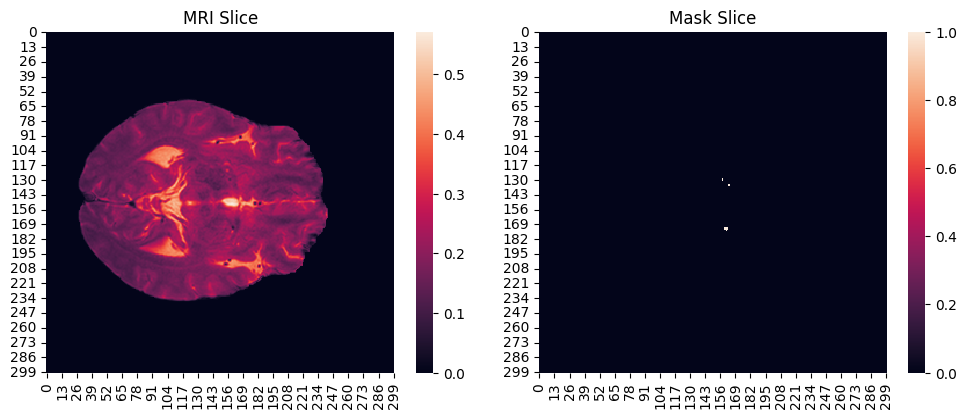

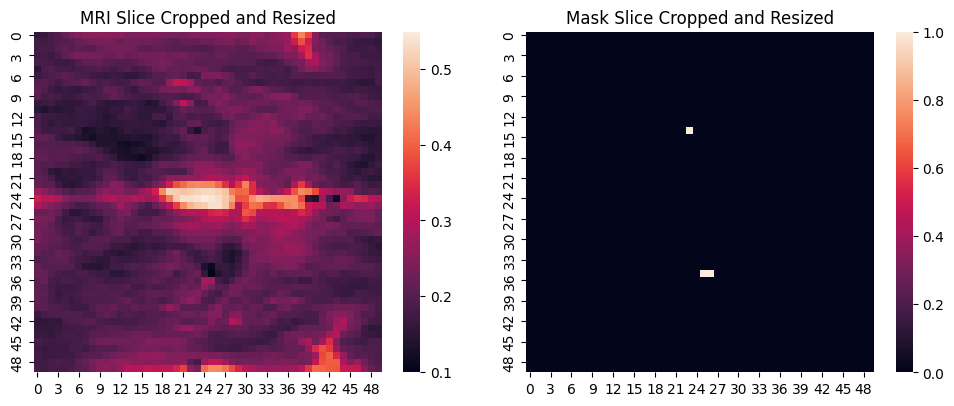

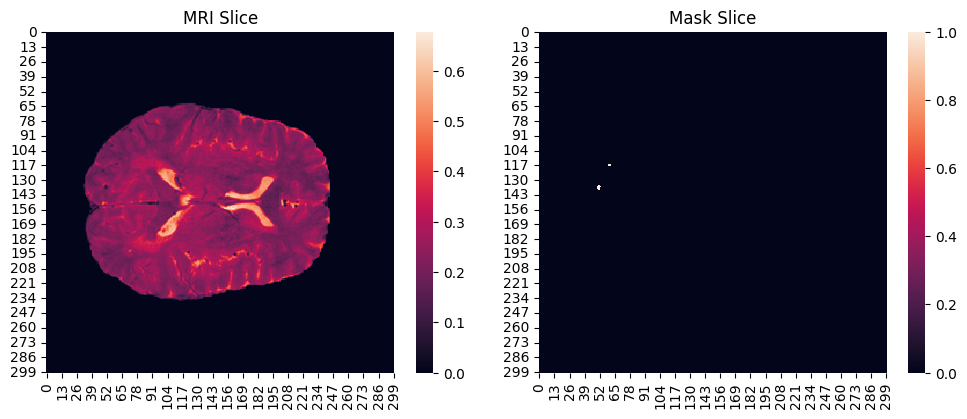

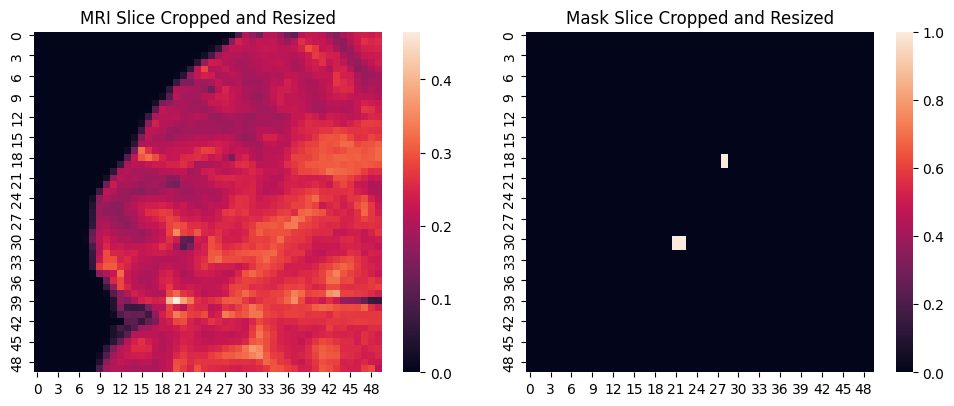

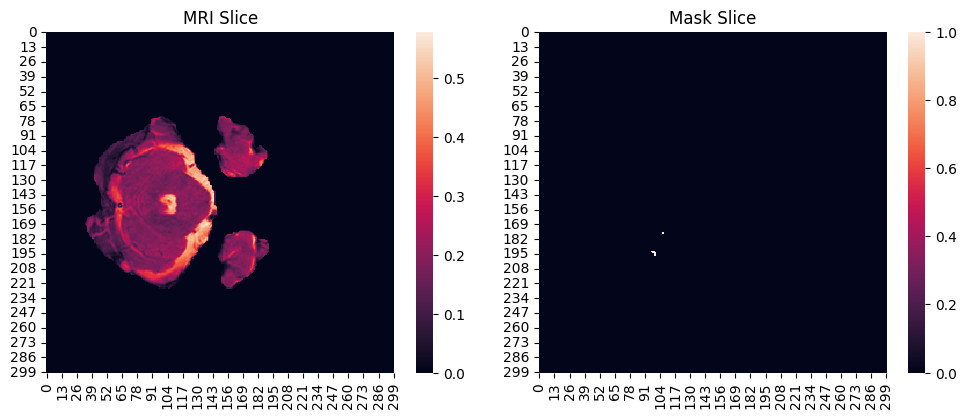

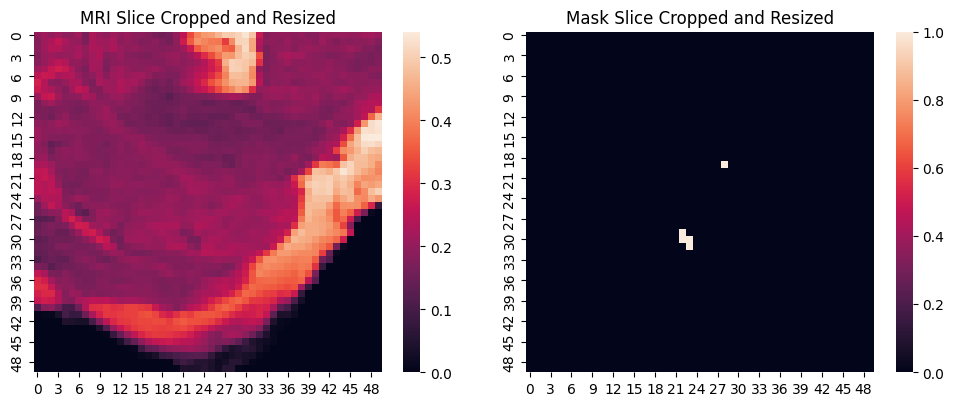

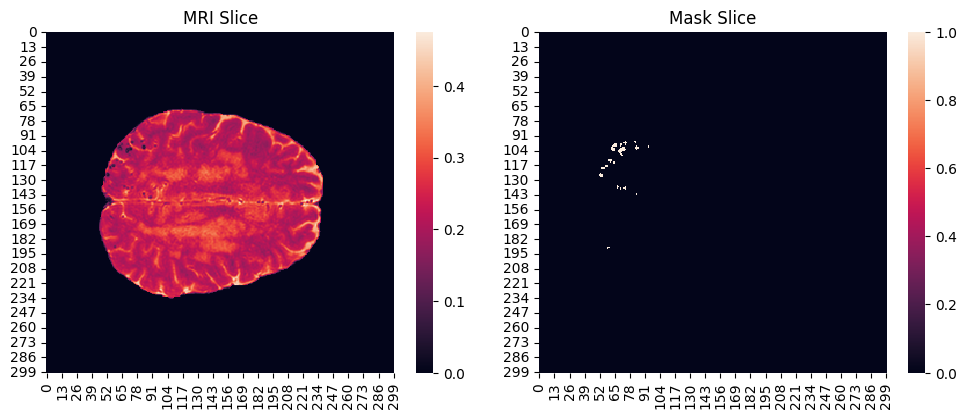

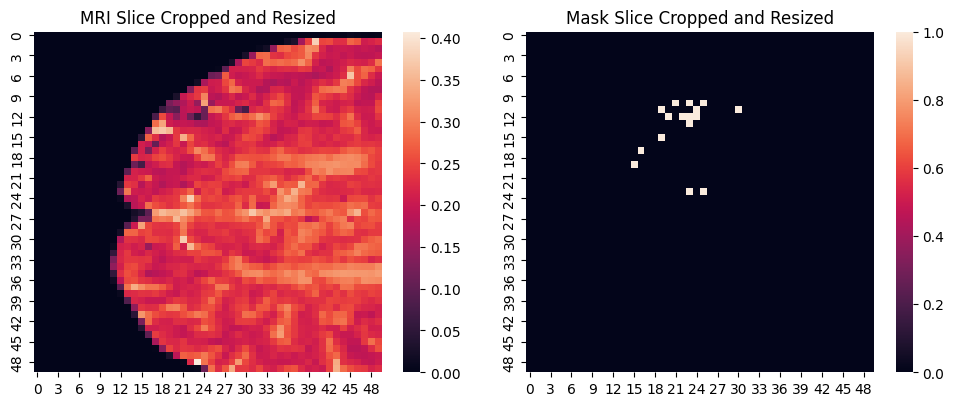

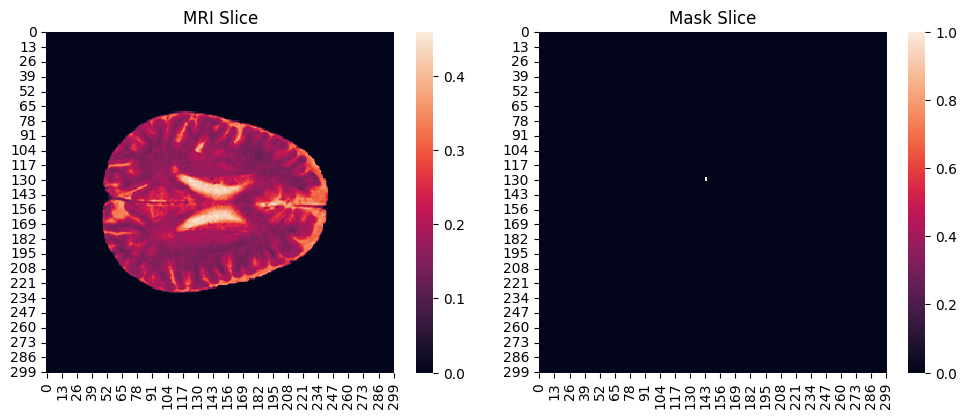

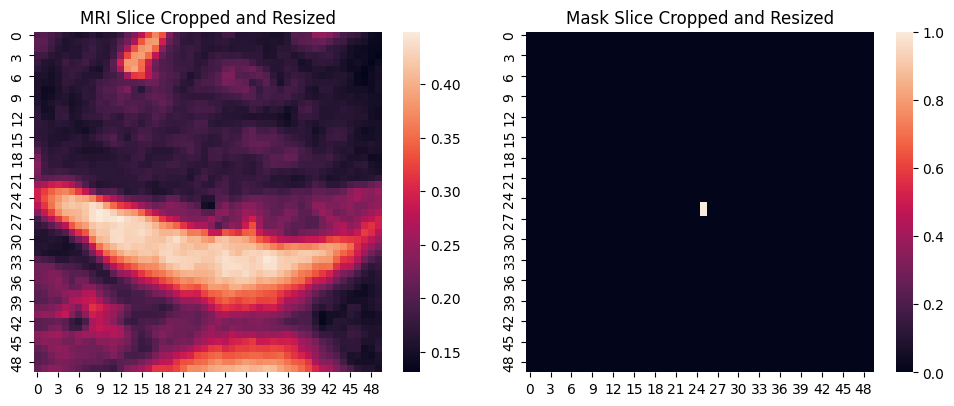

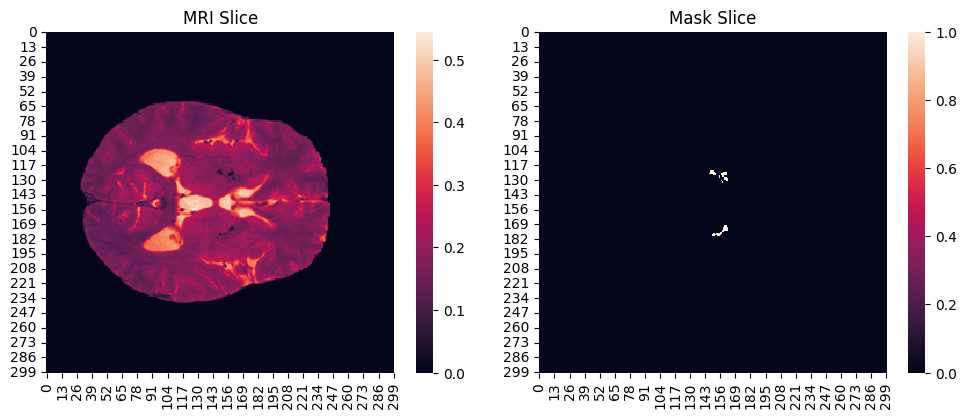

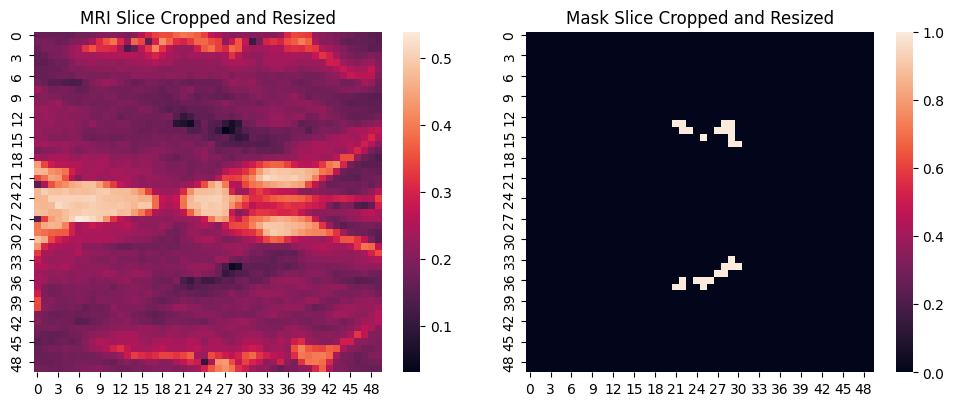

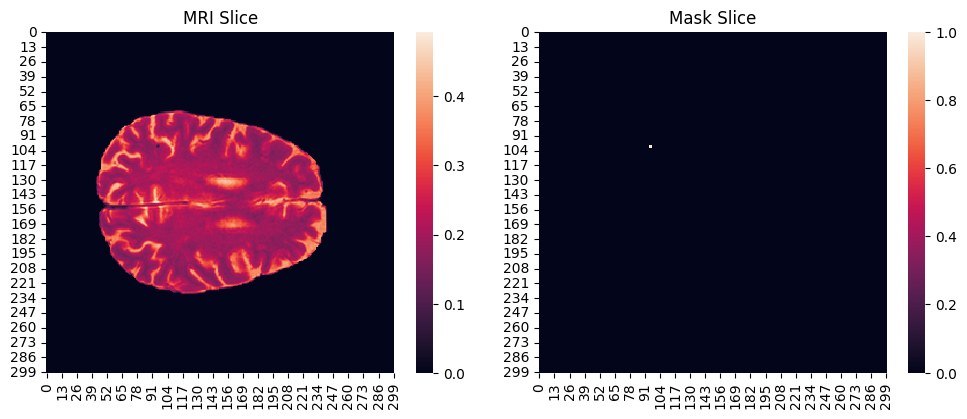

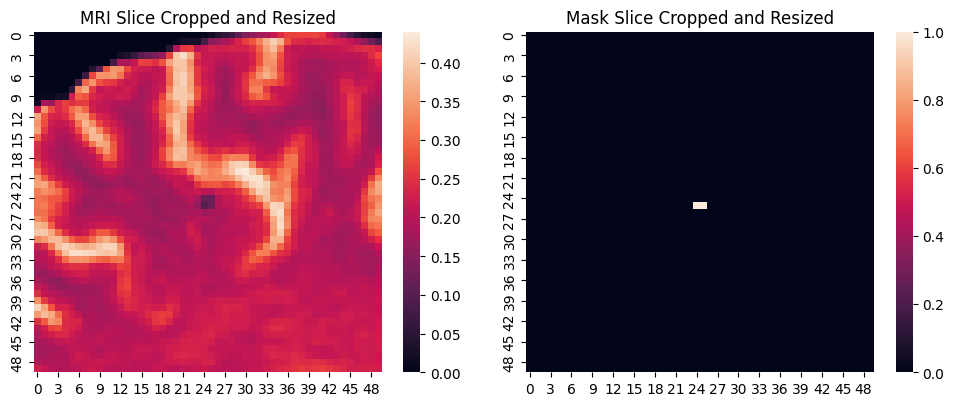

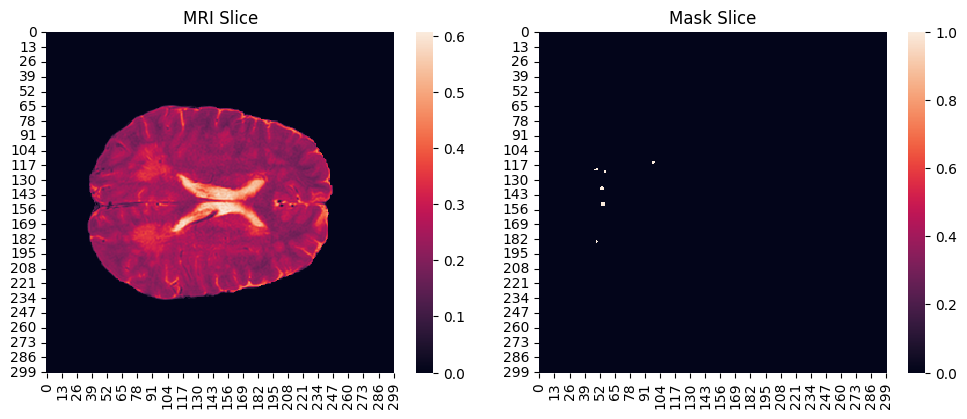

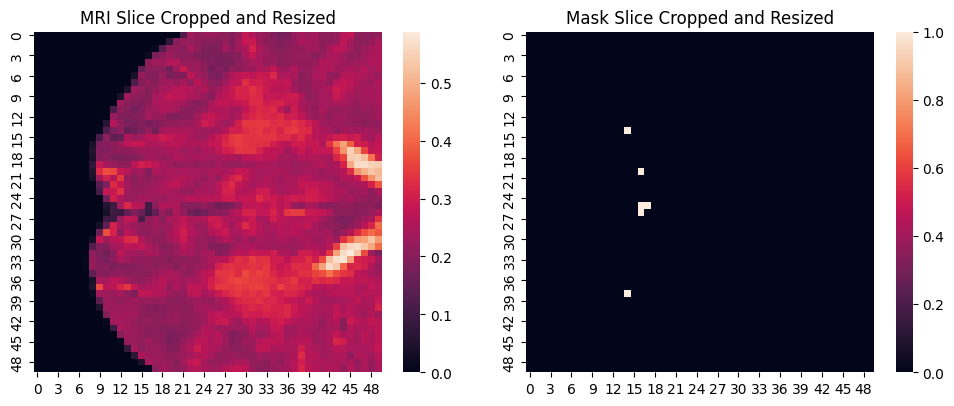

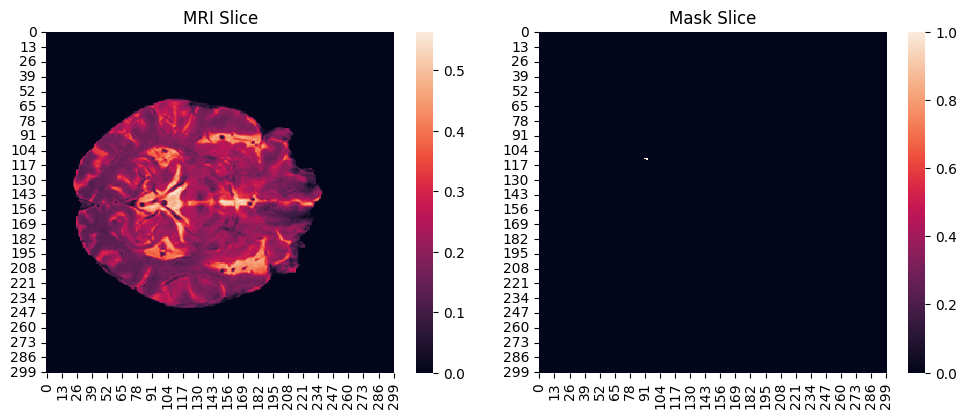

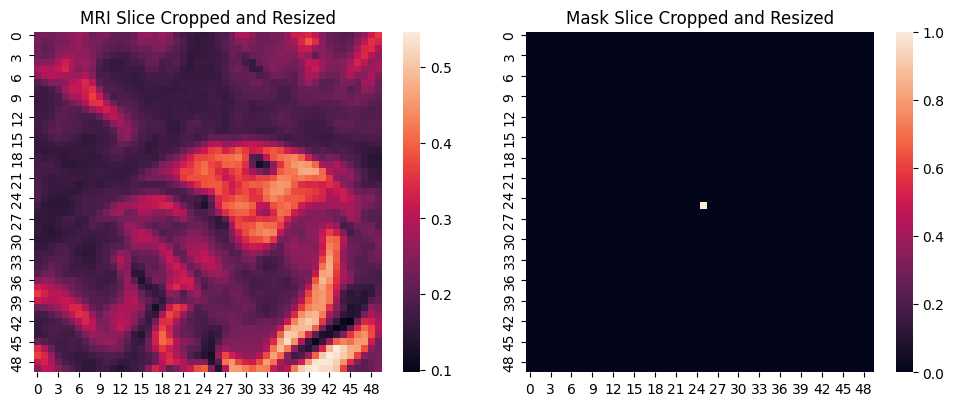

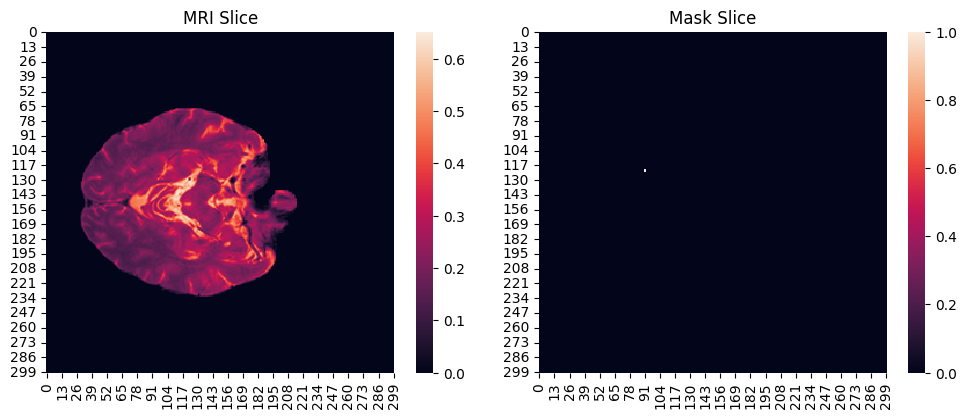

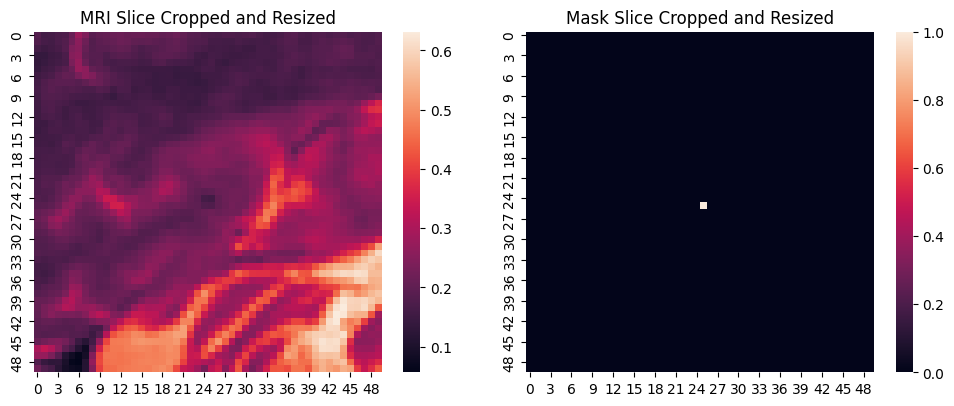

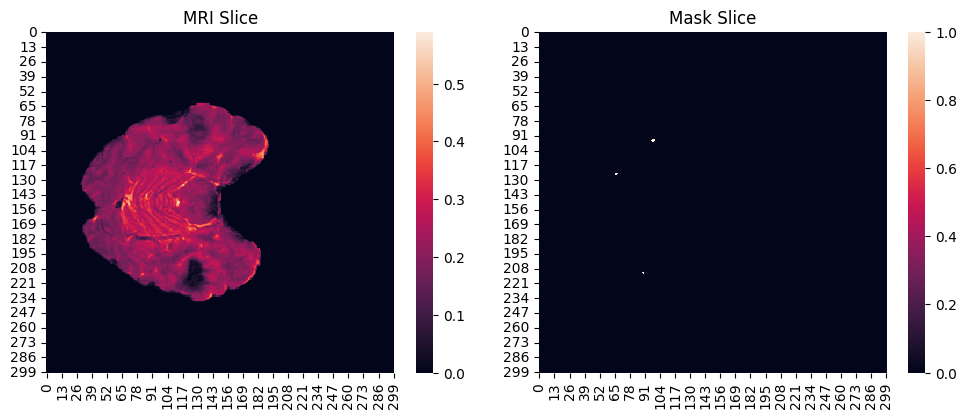

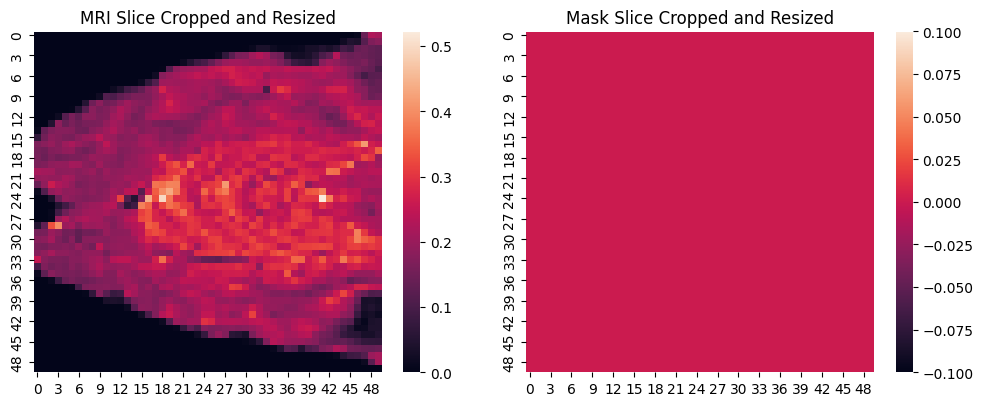

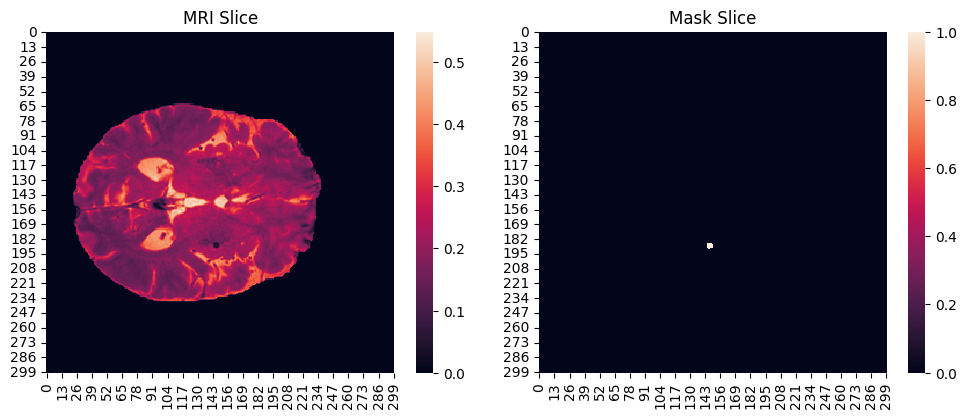

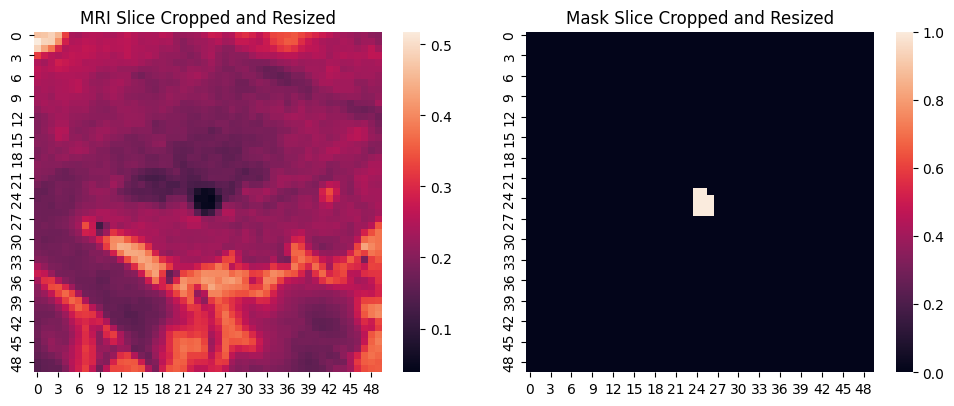

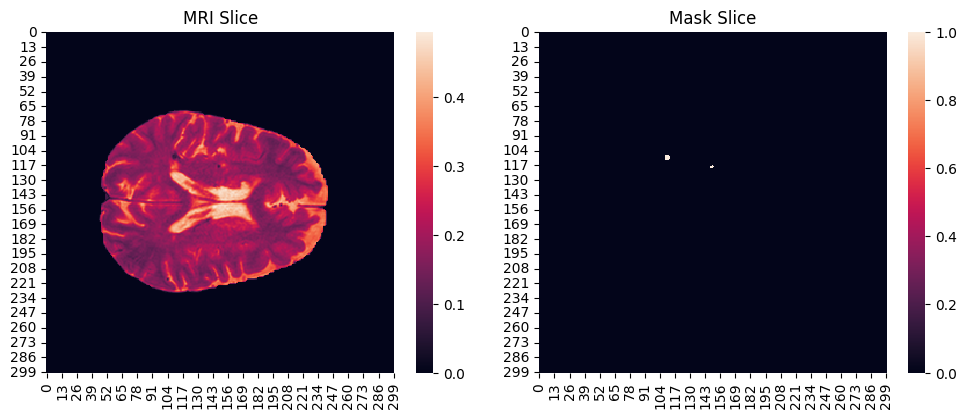

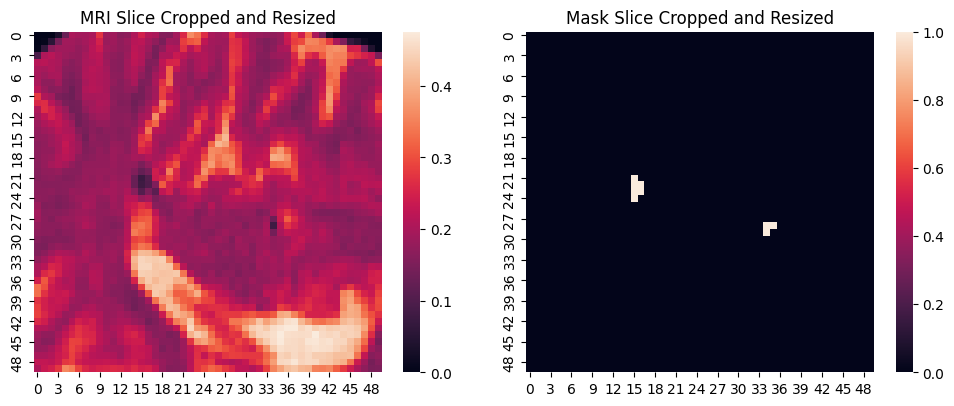

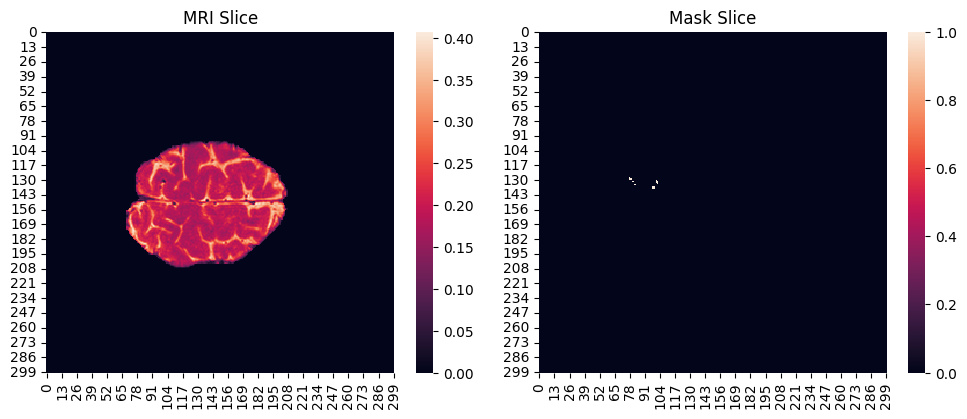

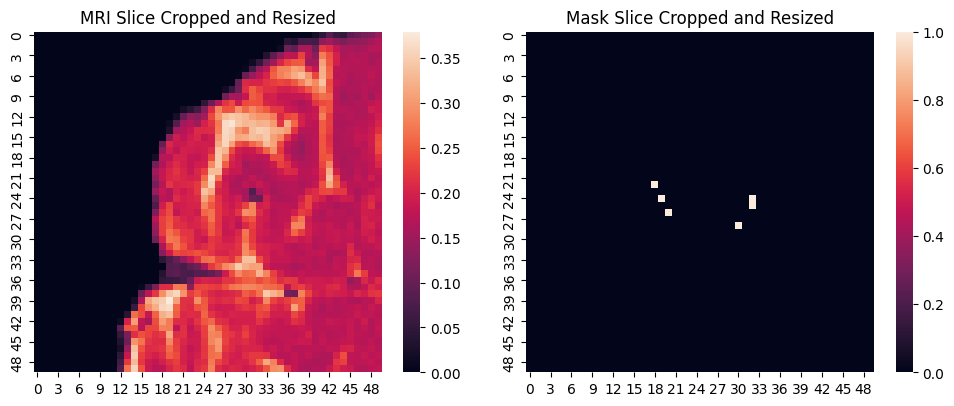

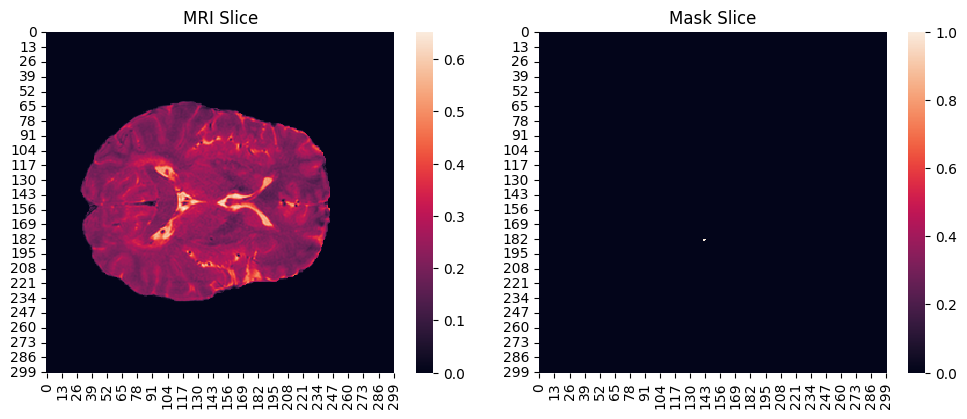

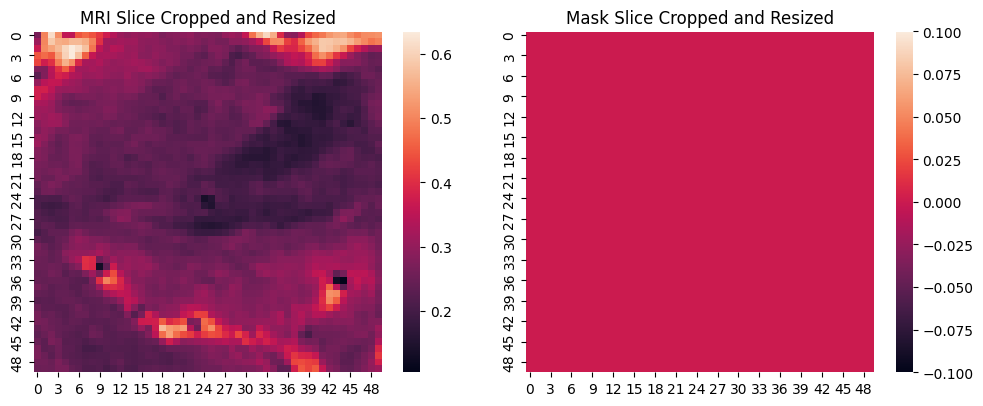

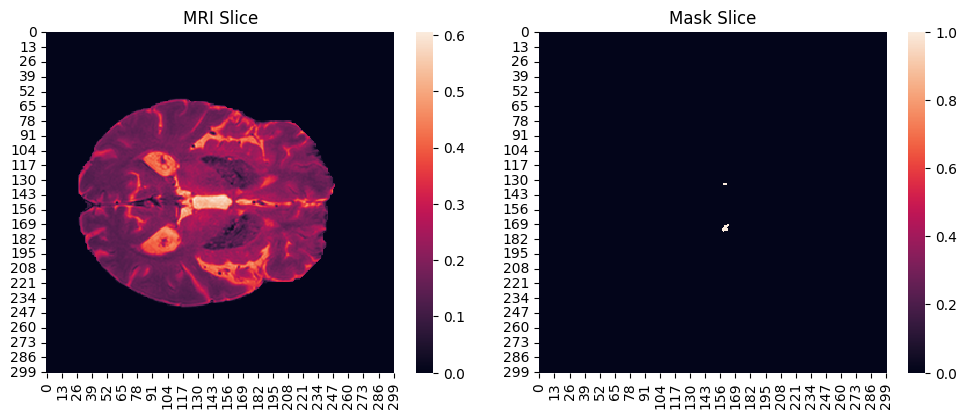

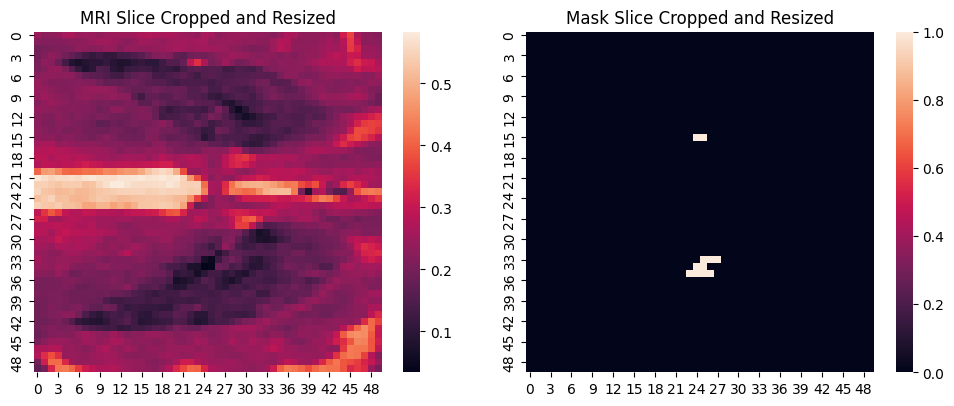

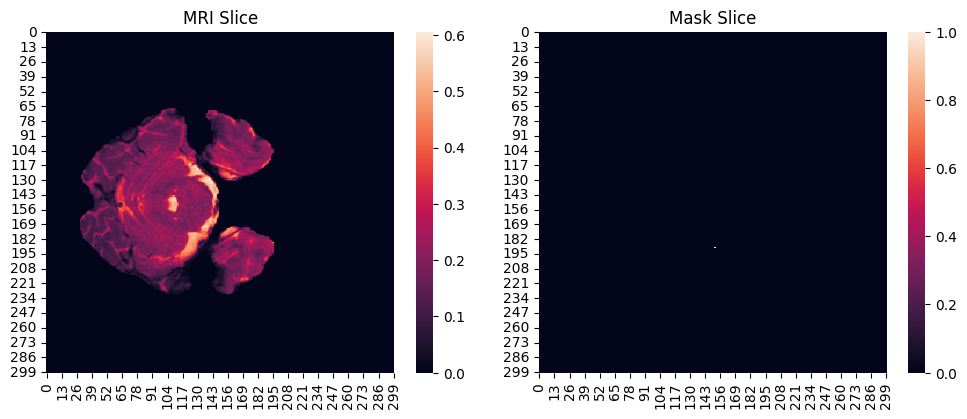

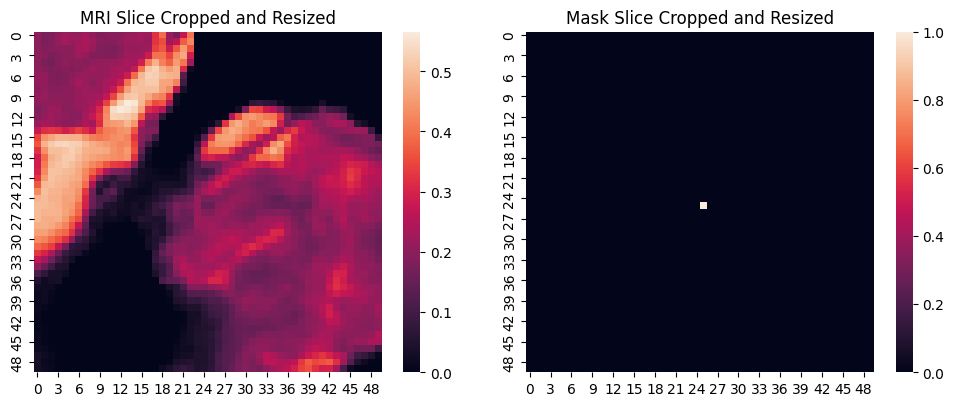

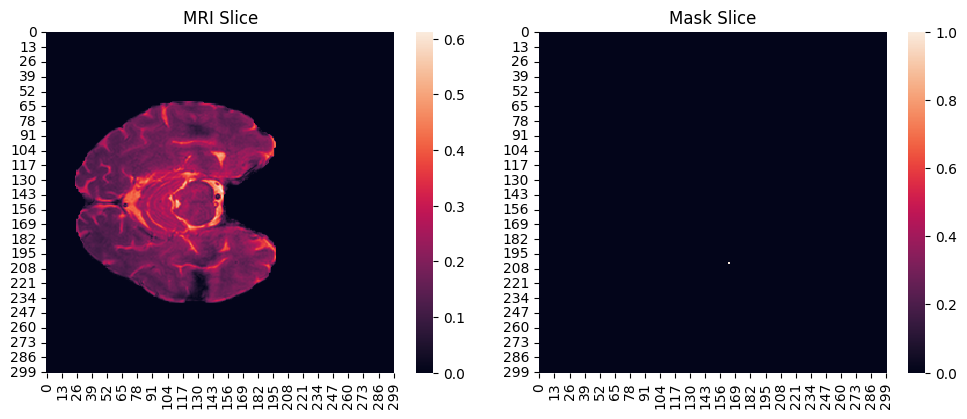

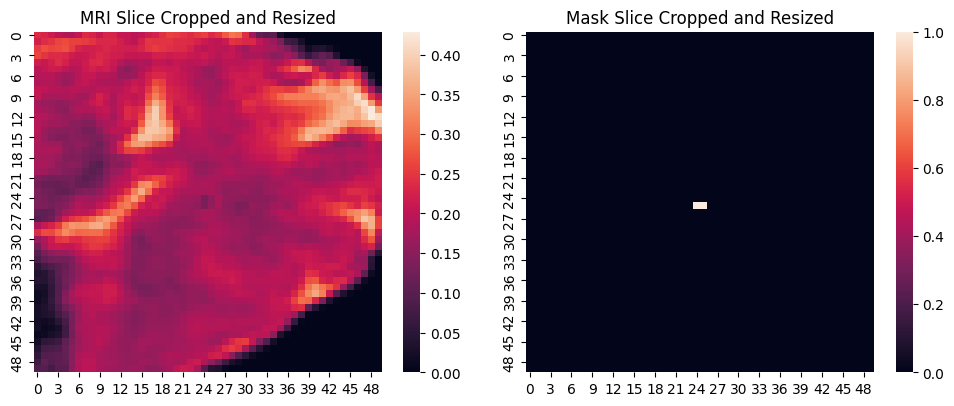

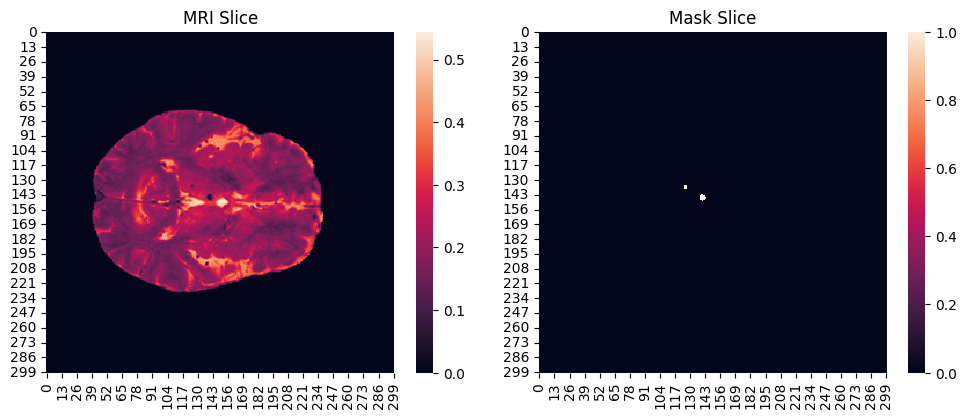

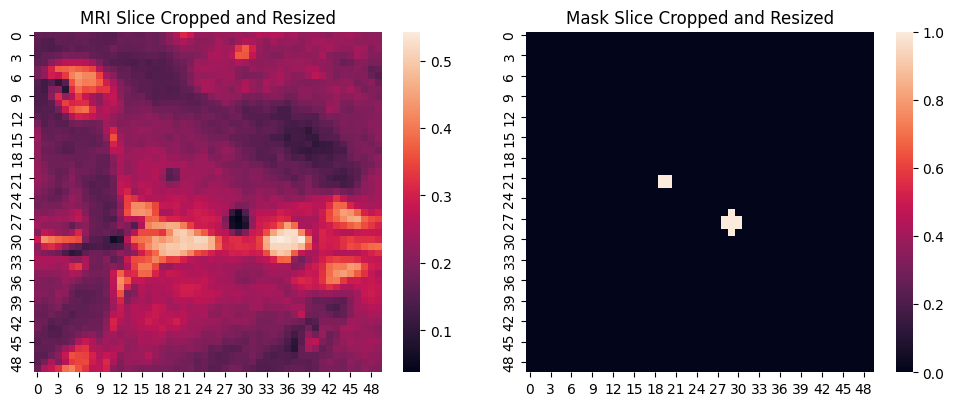

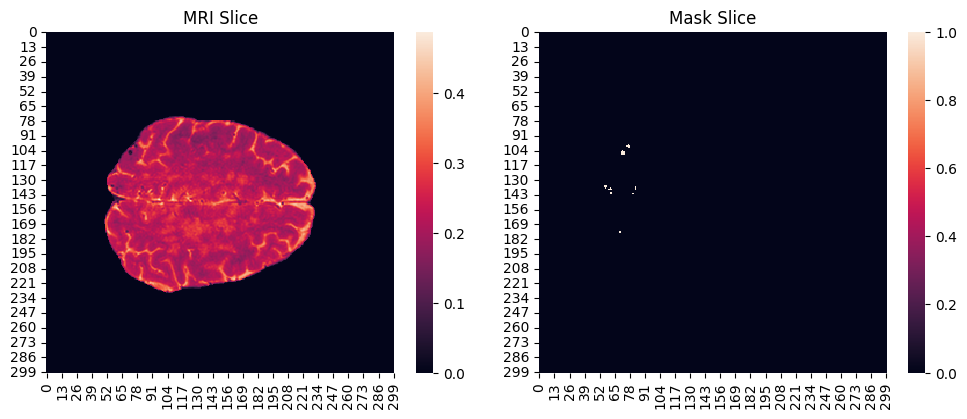

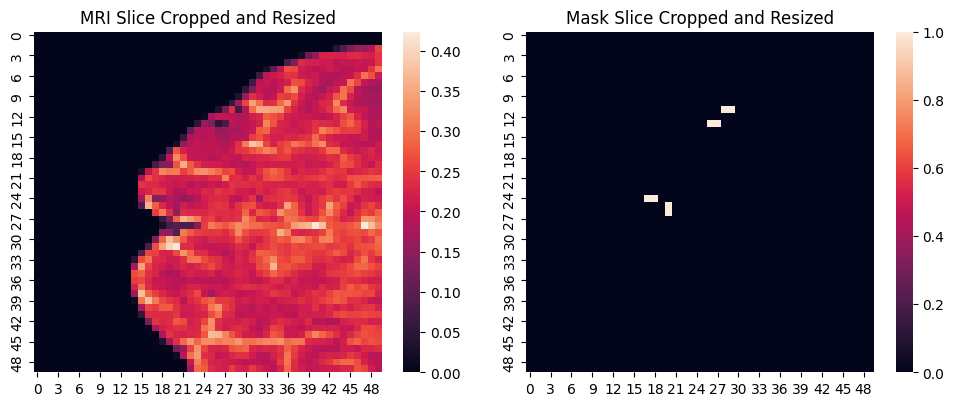

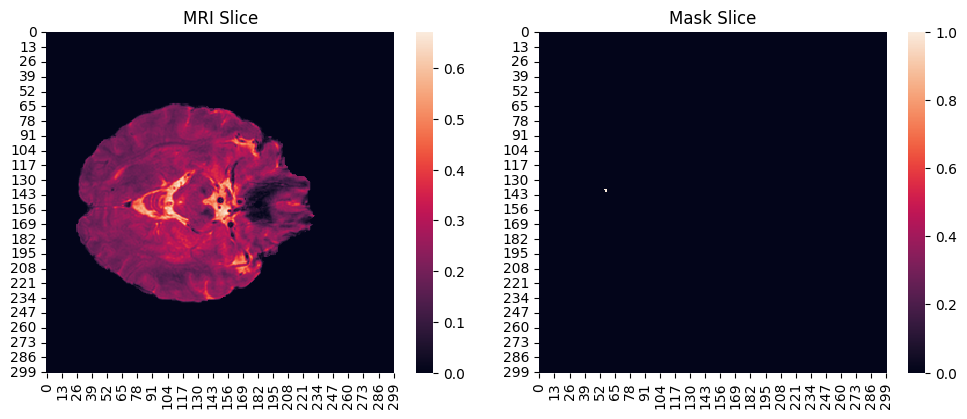

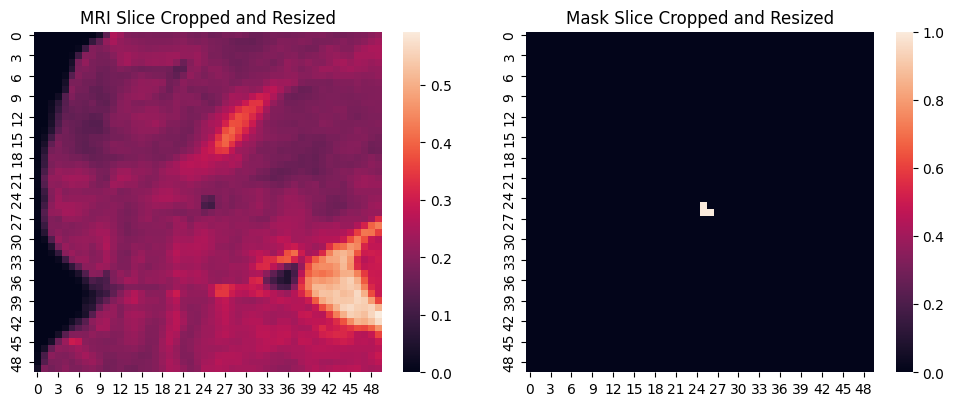

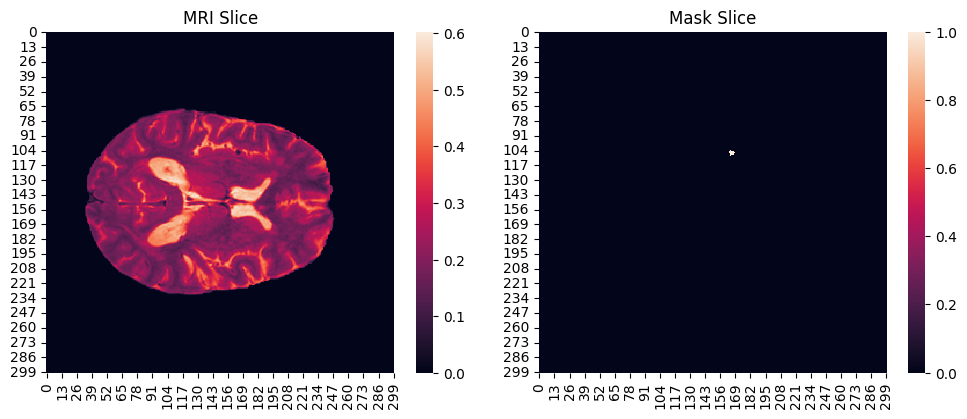

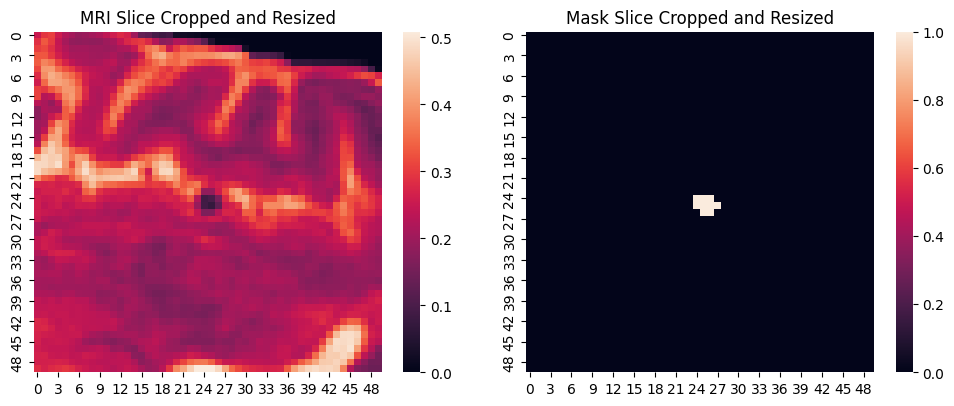

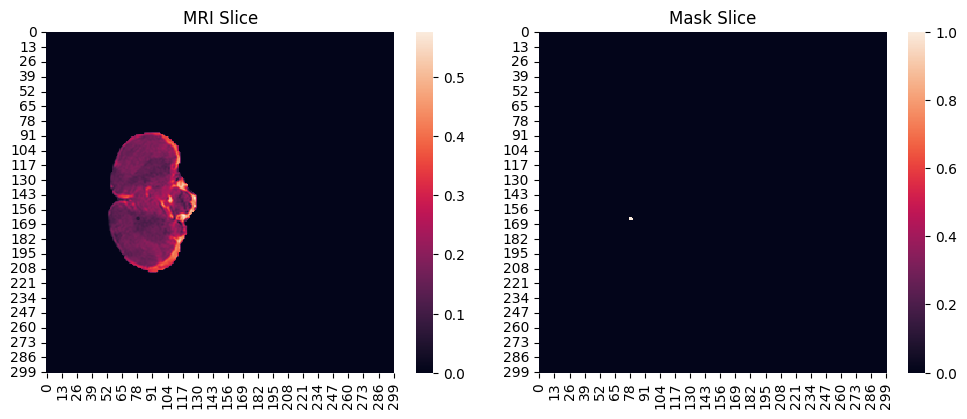

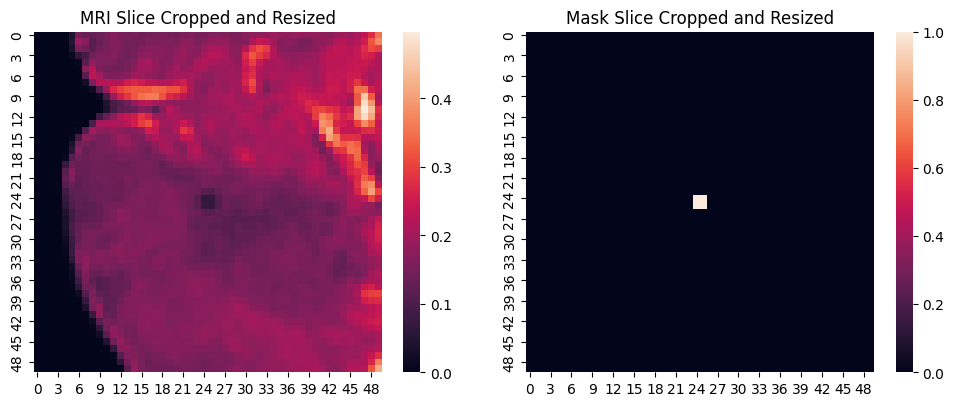

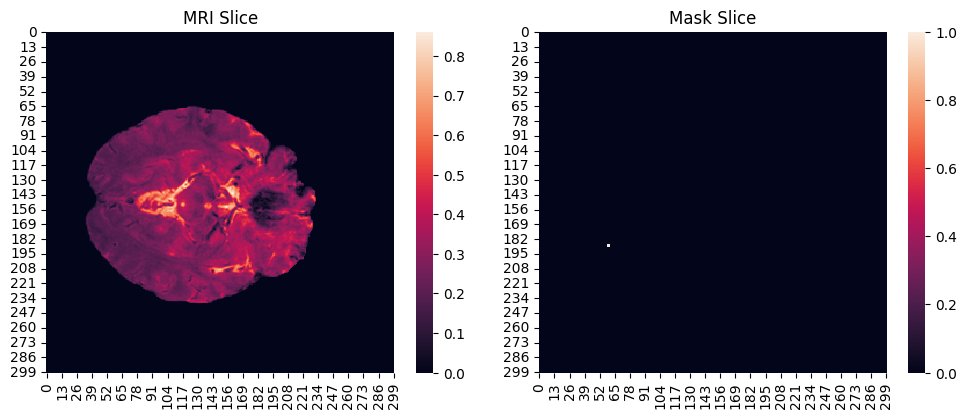

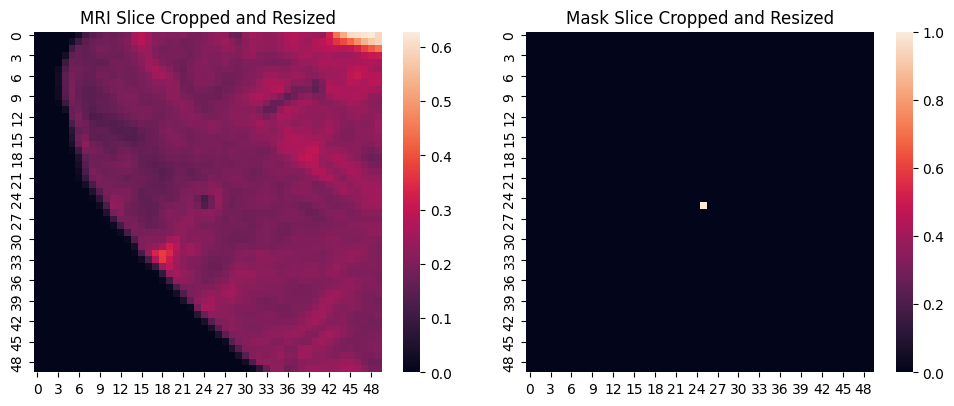

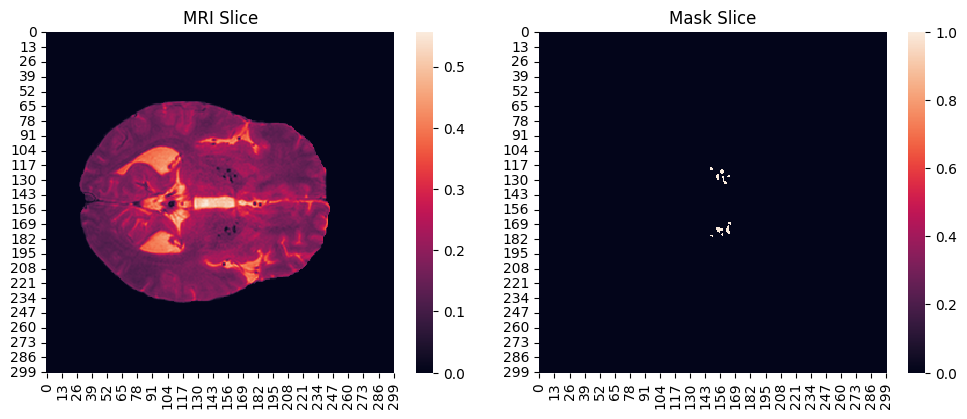

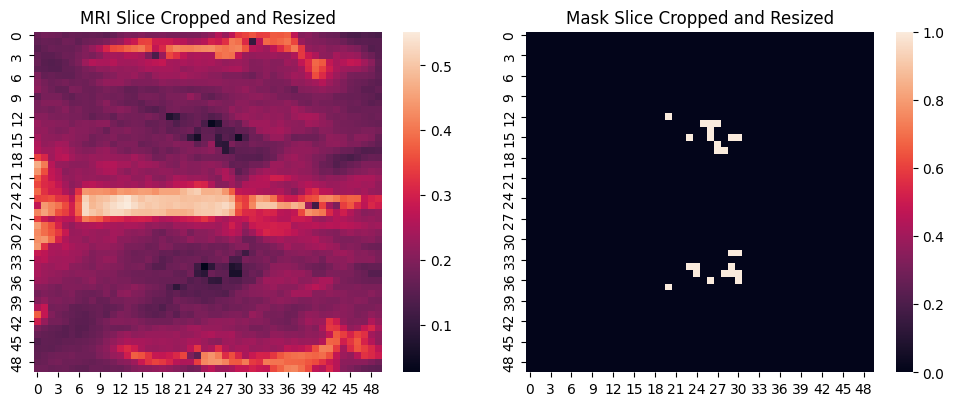

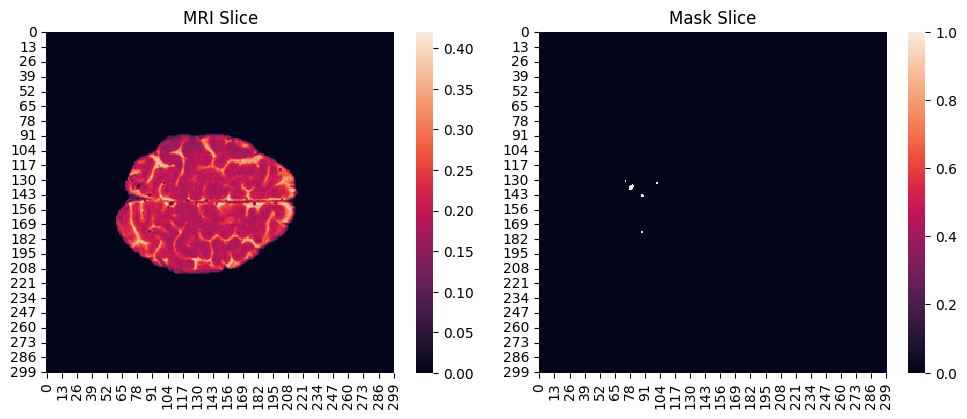

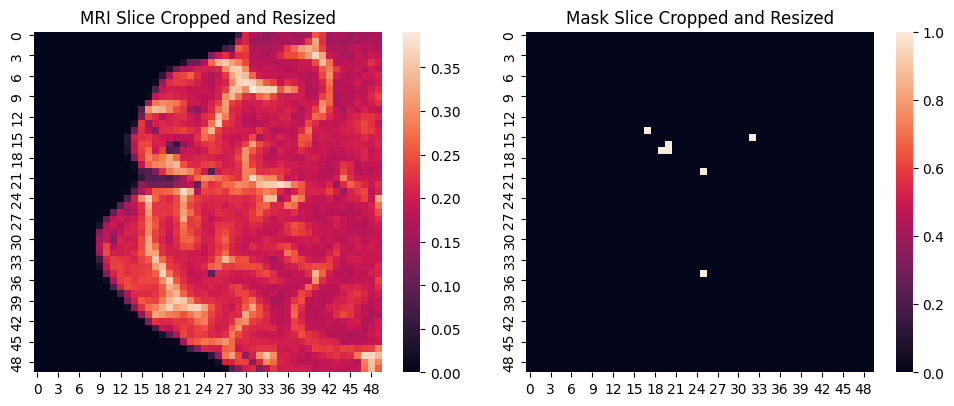

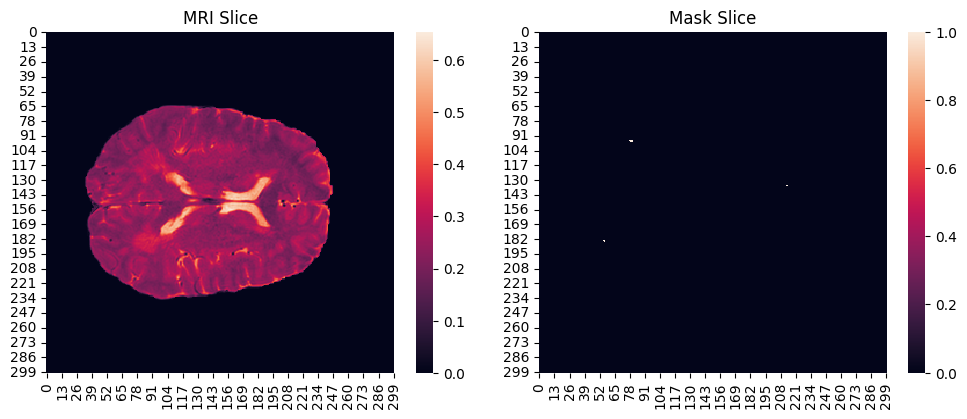

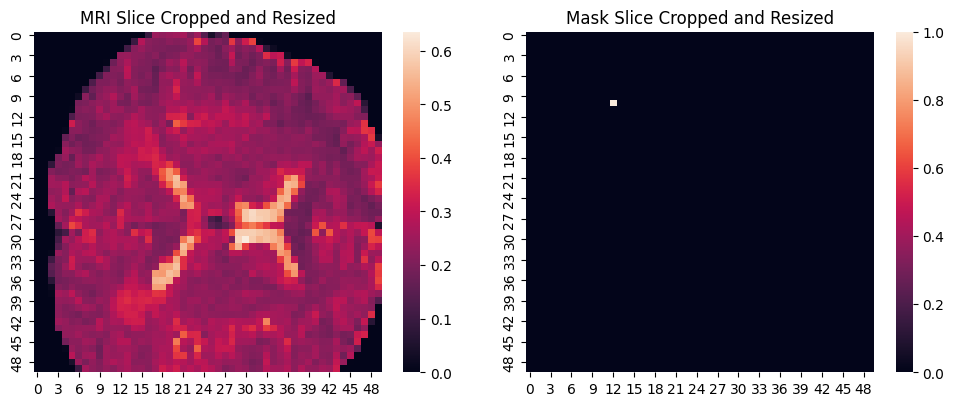

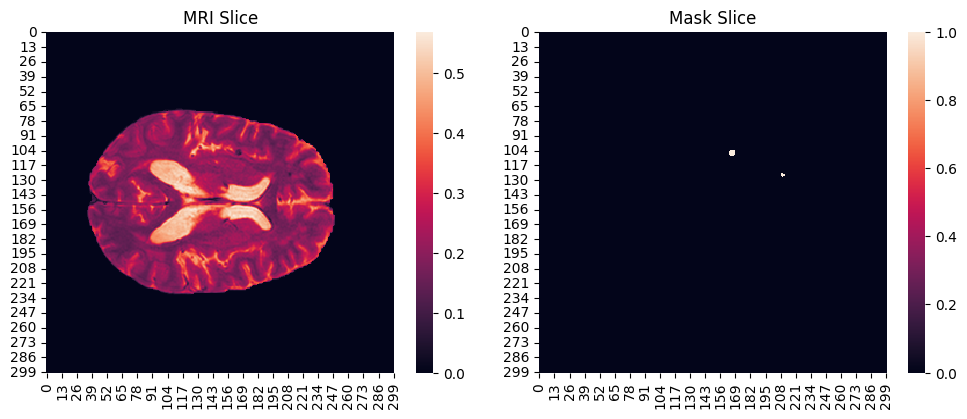

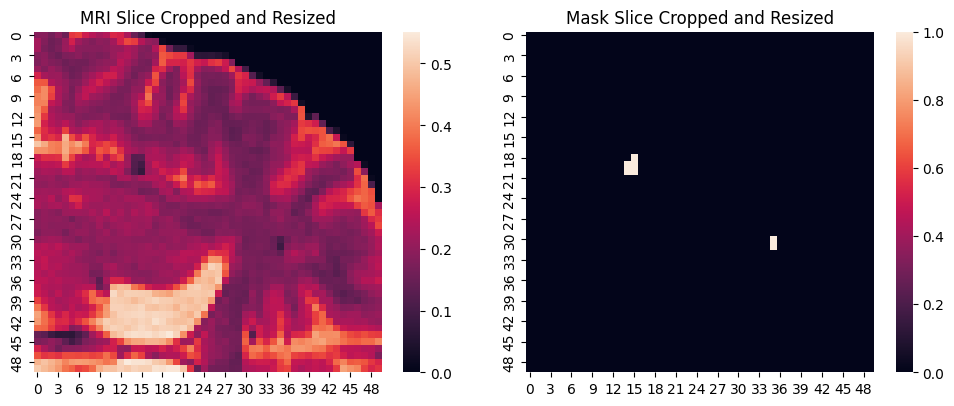

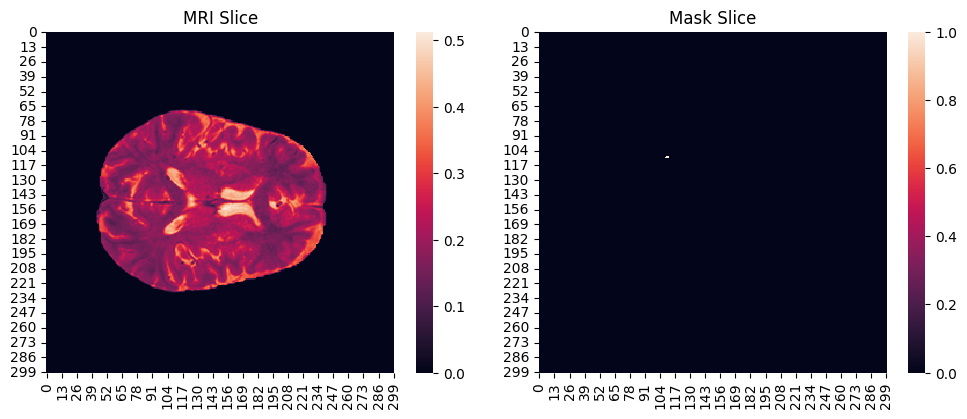

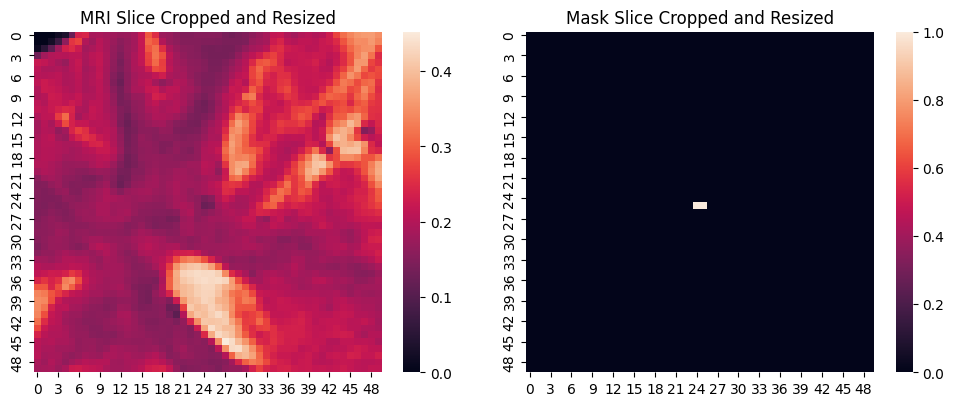

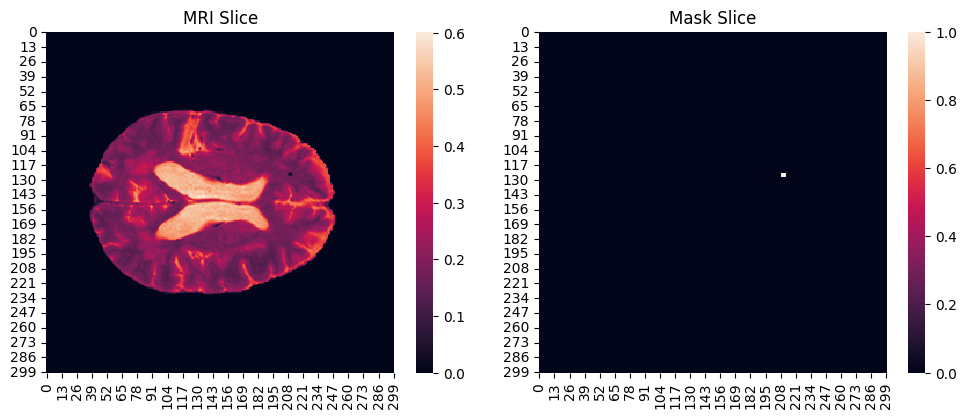

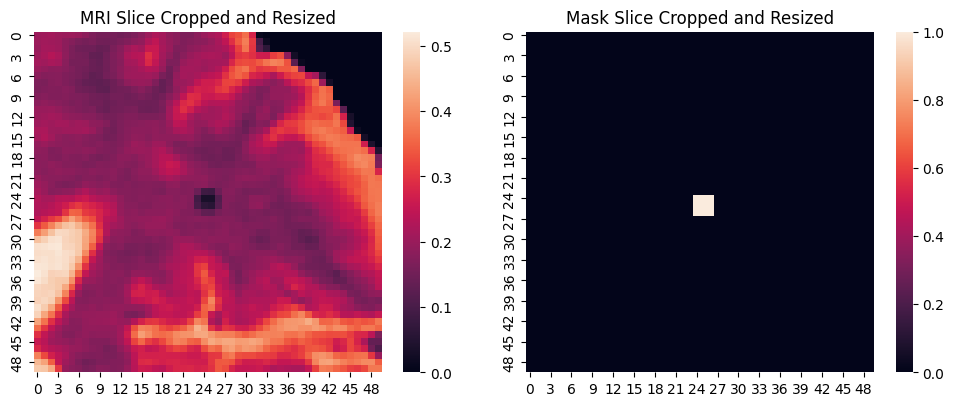

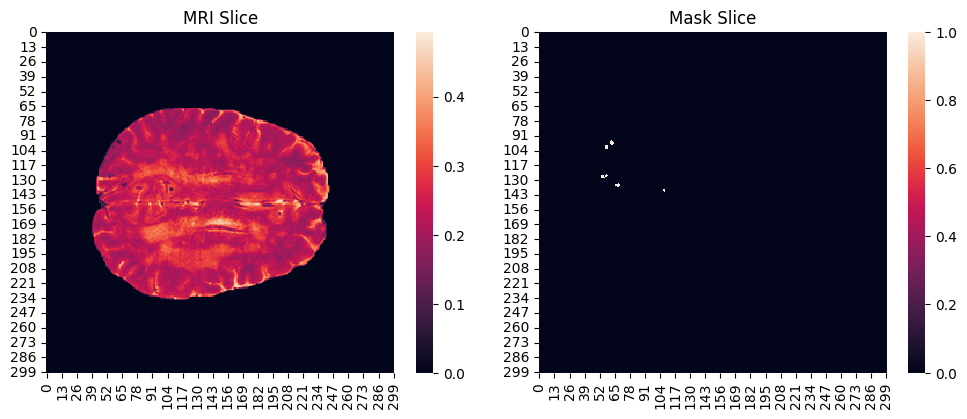

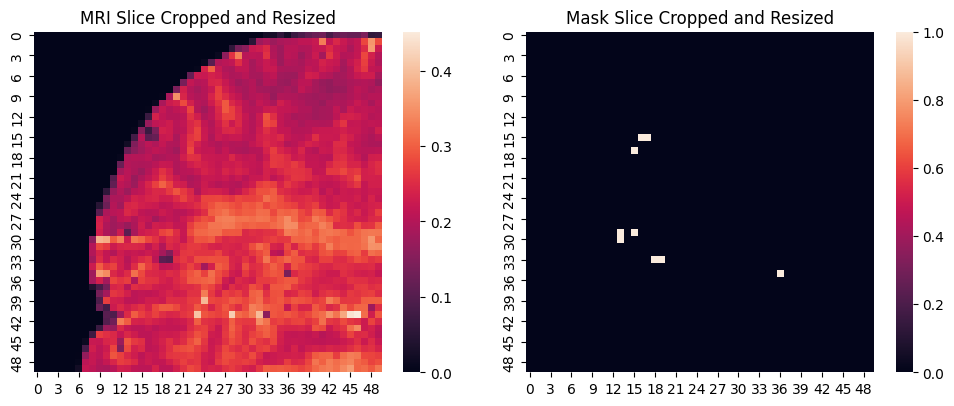

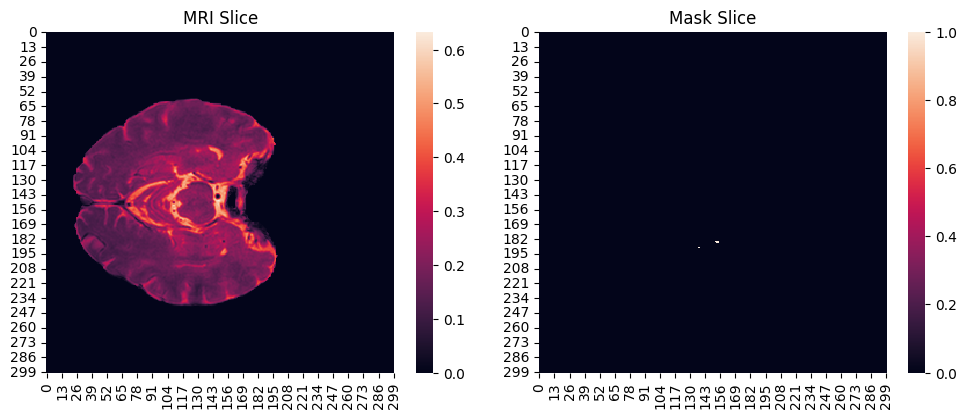

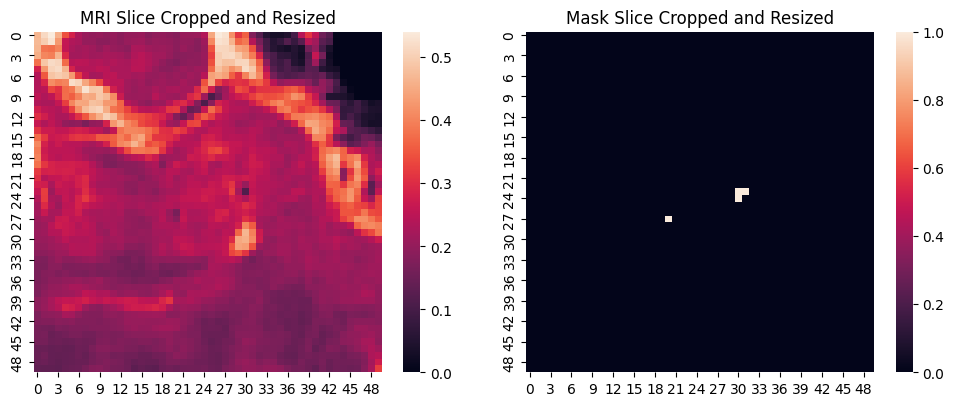

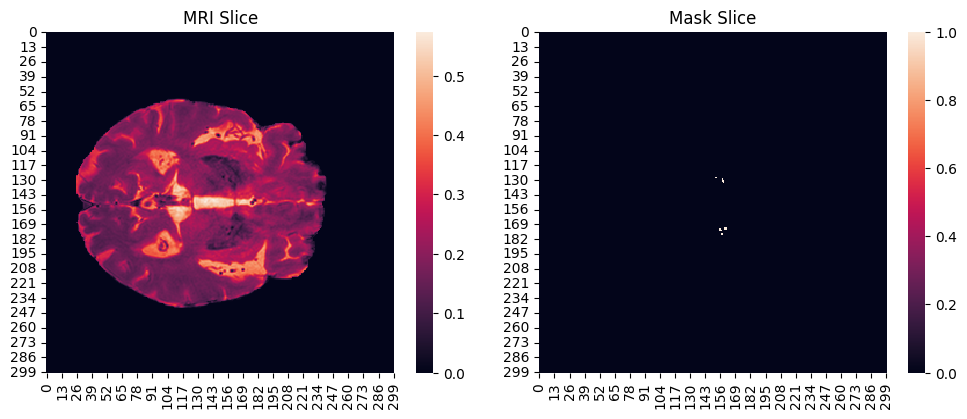

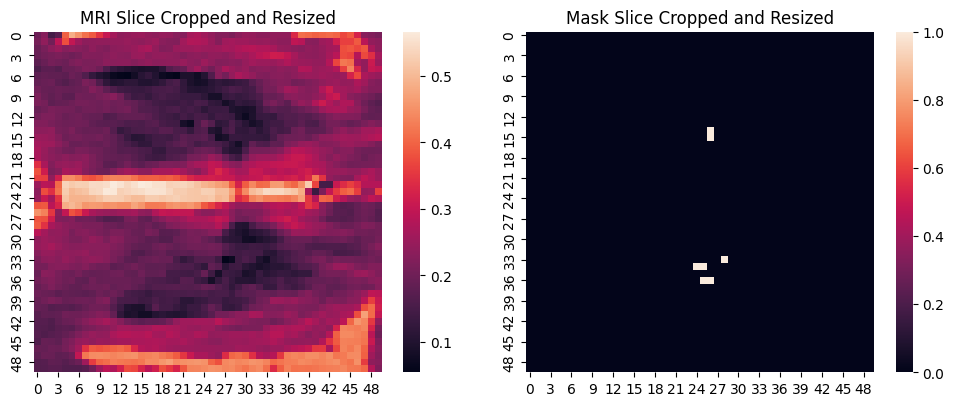

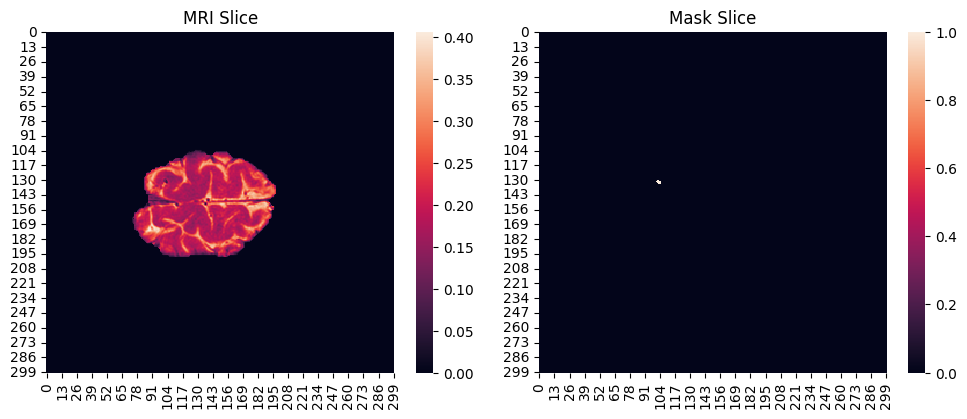

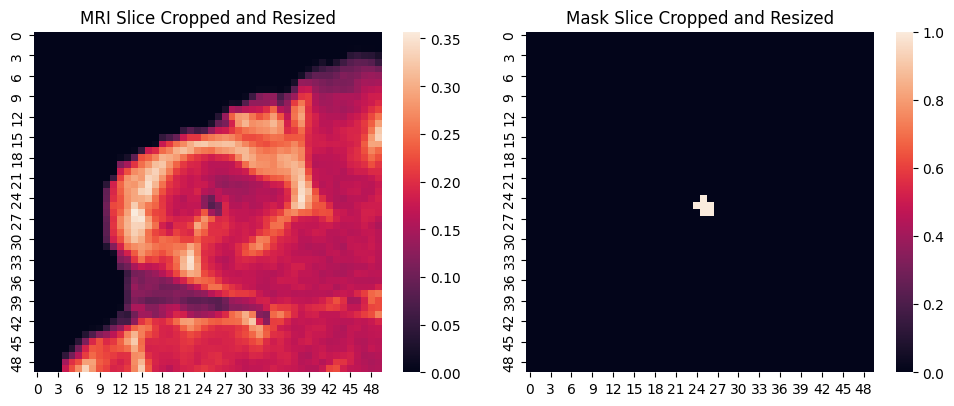

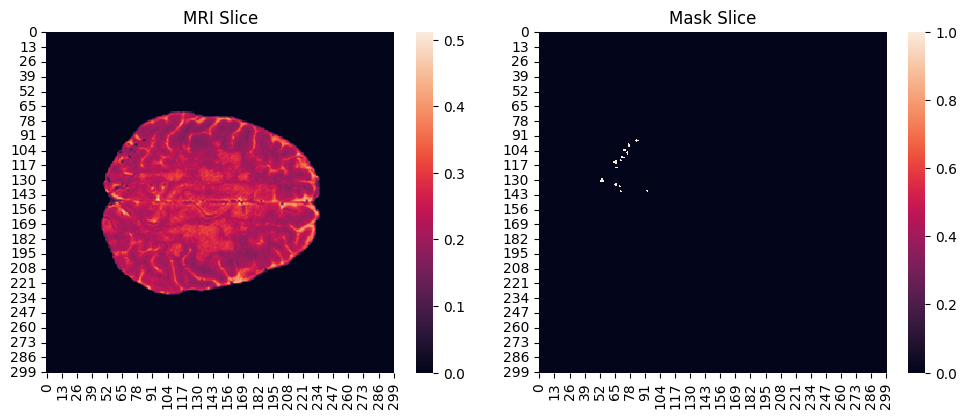

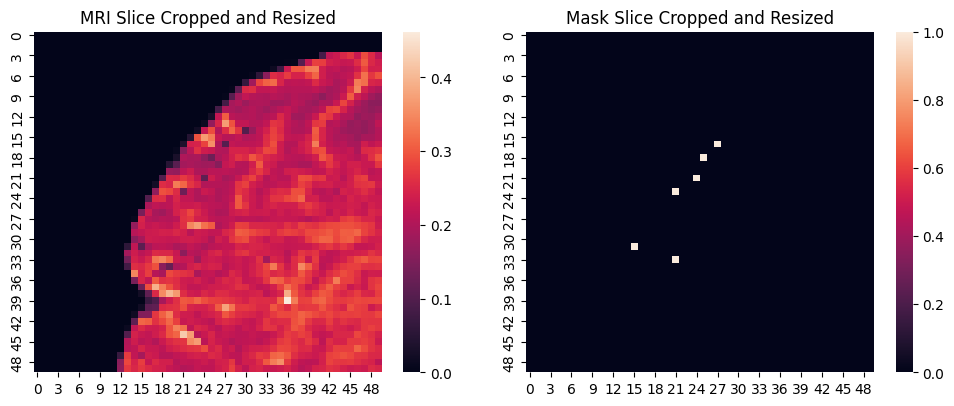

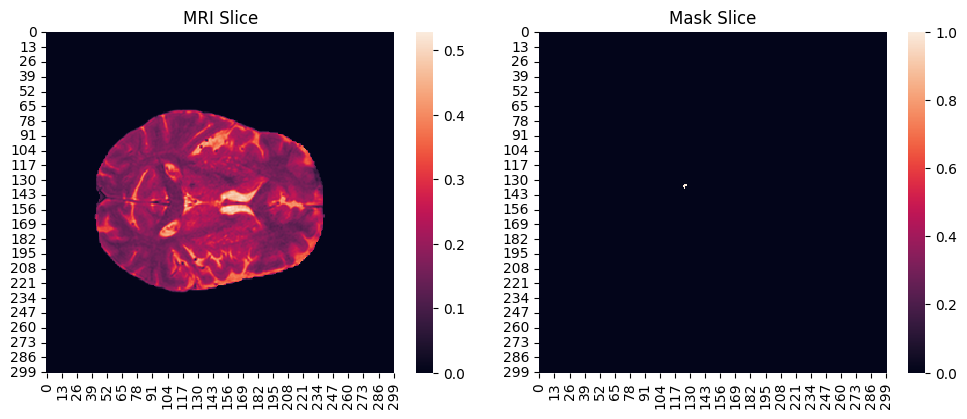

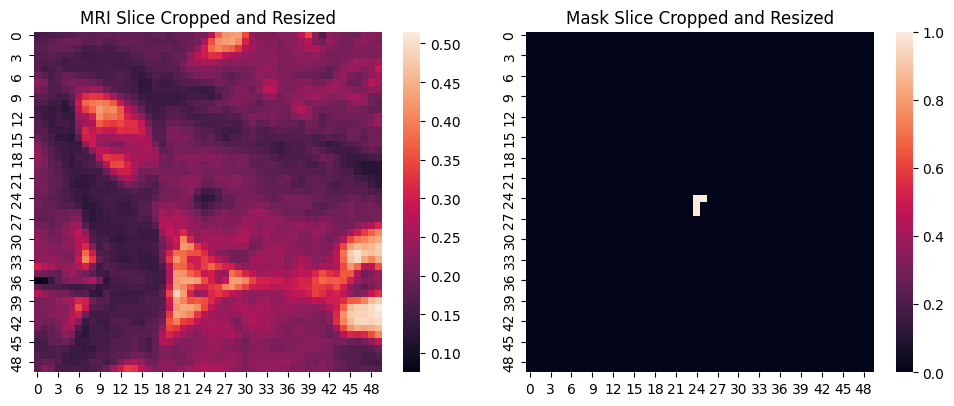

In [53]:

for batch in tl:
    for slices, masks, target, case in batch:
        regions = feedset.locate_case_by_mri(case)
        bbox = regions[1][target].squeeze().round().int().tolist()
        x_min, y_min, x_max, y_max = bbox
        print(bbox)
        print(aspect_ratio(bbox))
        f, a = plt.subplots(1, 2, figsize=(10, 4))

        f.tight_layout()
        ax1 = a.flat[0]
        ax2 = a.flat[1]
        ax1.set_title('MRI Slice')
        ax2.set_title('Mask Slice')
        sns.heatmap(slices[target].squeeze(), ax=ax1)
        sns.heatmap(masks[target].squeeze(), ax=ax2)

        x = feeder(slices, bbox, 100)
        t = feeder(masks, bbox, 100)

        print(x.shape)
        print(t.shape)

        f, a = plt.subplots(1, 2, figsize=(10, 4))

        f.tight_layout()
        ax1 = a.flat[0]
        ax2 = a.flat[1]
        ax1.set_title('MRI Slice Cropped and Resized')
        ax2.set_title('Mask Slice Cropped and Resized')
        sns.heatmap(x[target].squeeze(), ax=ax1)
        sns.heatmap(t[target].squeeze(), ax=ax2)
        
    

In [54]:
thist, vhist = fitter.fit(tl, vl)

In [55]:
import winsound

winsound.Beep(500, 500)
winsound.Beep(500, 500)
winsound.Beep(500, 500)

<Axes: >

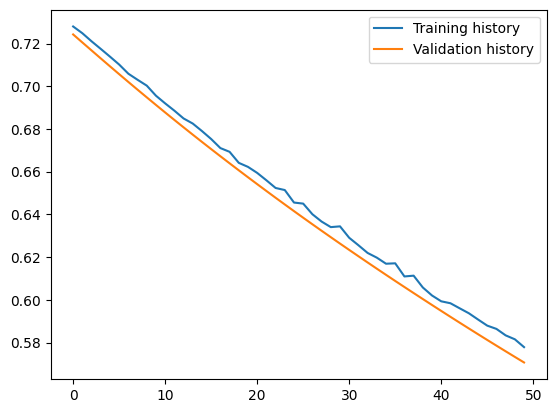

In [56]:
import seaborn as sns
import numpy as np

th = torch.tensor(np.array(thist))
vh = torch.tensor(np.array(vhist))
# print(th.shape)
sns.lineplot(th.mean(1), label='Training history')
sns.lineplot(vh.mean(1), label='Validation history')

In [57]:
import datetime

s = f'vit_test_weights_{datetime.datetime.now().strftime("%d%m%y%H%M%S")}.pt'
model = config['model']
torch.save(model.state_dict(), s)